#### Udacity Data Analyst Nanodegree
#### Communicate Data Findings - Project Submission
Ryan Middleton, May 2019

# Greatness According to Elo

This notebook documents the data exploration steps taken for this project. An introduction can be found in [readme.md](readme.md).

## Exploratory Data Analysis

We will be exploring two datasets:
1. **nba_elo.csv**: [FiveThirtyEight](https://fivethirtyeight.com/)'s NBA Elo ratings to May 2019
2. **basketball-reference-seasons.csv**: Historical NBA data compiled from [Basketball Reference](https://www.basketball-reference.com/)

<!-- ### What is the structure of your dataset? -->
First, let's set up our the environment and load the primary dataset:

In [1]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display, HTML
from matplotlib import pyplot as plt

#for notebook
%matplotlib inline

#seaborn settings
sns.set_style('whitegrid');

In [2]:
df_nba_elo = pd.read_csv('nba_elo.csv')
df_nba_elo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68404 entries, 0 to 68403
Data columns (total 24 columns):
date              68404 non-null object
season            68404 non-null int64
neutral           68404 non-null int64
playoff           4360 non-null object
team1             68404 non-null object
team2             68404 non-null object
elo1_pre          68404 non-null float64
elo2_pre          68404 non-null float64
elo_prob1         68404 non-null float64
elo_prob2         68404 non-null float64
elo1_post         68395 non-null float64
elo2_post         68395 non-null float64
carm-elo1_pre     5247 non-null float64
carm-elo2_pre     5247 non-null float64
carm-elo1_post    5238 non-null float64
carm-elo2_post    5238 non-null float64
carm-elo_prob1    5247 non-null float64
carm-elo_prob2    5247 non-null float64
carmelo1_pre      1310 non-null float64
carmelo2_pre      1310 non-null float64
carmelo_prob1     1310 non-null float64
carmelo_prob2     1310 non-null float64
score1  

In [3]:
df_seasons = pd.read_csv('basketball-reference-seasons.csv')
df_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 4 columns):
season      93 non-null int64
lg          93 non-null object
top_seed    69 non-null object
champion    93 non-null object
dtypes: int64(1), object(3)
memory usage: 3.0+ KB


Some notes about these datasets:
- The *nba_elo* dataset is structured based on game-by-game observation - pre-game and post-game Elo ratings. There are more than 68k games in the history of the NBA and its related leagues.
- Games include date and a playoff stage classification. The game-by-game format will be useful for observing ratings in time series, and higher-order performance in regular season vs. playoffs. However, since we are mostly interested in observing teams' histories (especially the "great" ones), it will help to transform the data into observations per-team.
- Missing scores only apply to NBL games (not from the "modern" era after the NBA/ABA merger). These are not a concern as we will primarily consider summary results and more recent ratings.
- Note that there is a relatively small number of "CARMELO" ratings - these can be dropped, since we won't use them for this project.
- The *basketball-reference-seasons* dataset includes top seeds only for NBA seasons (we won't use them for pre- NBA/ABA merger seasons). 
- When observing the data, keep in mind that the `season` column in both datasets represents the end year of a given season.

<!-- ### What is/are the main feature(s) of interest in your dataset? -->
<!-- ### What features in the dataset do you think will help support your investigation into your feature(s) of interest? -->
As we are looking at how Elo might help understand historical greatness in the NBA, the following features are of particular interest:
- `elo_post` can be used for most summary calculations, as the per-game result (as opposed to the pre-game rating). 
  - We will define categories for setting teams apart based on their Elo performance.
  - Elo streaks can also be used as a proxy for calculating win streaks.
- Grouping by `season` and `team` will be necessary to visualize overall performance. Game-by-game results are noisy.
- Specific `playoff` categories are not so useful, but we can check for `NULL` values to separate regular season and playoff Elos.
- We can use these features to calculate higher-order Elo metrics, such as season / regular season average per-team.
- Insofar as greatness relates to (or even predicts) championship results, we will also want to compare the best teams per Elo to the `champion` team for each season.

In a future analysis, it would be interesting to compare Elo performance to changes in team valuation, and other questions of $$$ (the NBA is a business, after all). However, such analysis is not incorporated in this version of the project.

We will have only partial results (i.e. post-game Elo ratings) for the 2018-19 season. So the following rows can be dropped for analysis:

In [4]:
df_nba_elo[df_nba_elo['elo1_post'].isnull()]

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo1_post,carm-elo2_post,carm-elo_prob1,carm-elo_prob2,carmelo1_pre,carmelo2_pre,carmelo_prob1,carmelo_prob2,score1,score2
68395,2019-05-19,2019,0,c,TOR,MIL,1658.485994,1725.215990,0.547734,0.452266,...,NaN,NaN,0.545942,0.454058,1790.769631,1803.414634,0.628052,0.371948,NaN,NaN
68396,2019-05-20,2019,0,c,POR,GSW,1640.226262,1706.347072,0.548602,0.451398,...,NaN,NaN,0.522366,0.477634,1606.423142,1693.353905,0.487073,0.512927,NaN,NaN
68397,2019-05-21,2019,0,c,TOR,MIL,1658.485994,1725.215990,0.547734,0.452266,...,NaN,NaN,0.545942,0.454058,1790.769631,1803.414634,0.628052,0.371948,NaN,NaN
68398,2019-05-22,2019,0,c,GSW,POR,1706.347072,1640.226262,0.722374,0.277626,...,NaN,NaN,0.726892,0.273108,1707.135398,1606.423142,0.768434,0.231566,NaN,NaN
68399,2019-05-23,2019,0,c,MIL,TOR,1725.215990,1658.485994,0.723077,0.276923,...,NaN,NaN,0.715326,0.284674,1803.414634,1790.769631,0.641485,0.358515,NaN,NaN
68400,2019-05-24,2019,0,c,POR,GSW,1640.226262,1706.347072,0.548602,0.451398,...,NaN,NaN,0.522366,0.477634,1606.423142,1741.445647,0.418591,0.581409,NaN,NaN
68401,2019-05-25,2019,0,c,TOR,MIL,1658.485994,1725.215990,0.547734,0.452266,...,NaN,NaN,0.545942,0.454058,1790.769631,1803.414634,0.628052,0.371948,NaN,NaN
68402,2019-05-26,2019,0,c,GSW,POR,1706.347072,1640.226262,0.722374,0.277626,...,NaN,NaN,0.726892,0.273108,1770.687791,1606.423142,0.827116,0.172884,NaN,NaN
68403,2019-05-27,2019,0,c,MIL,TOR,1725.215990,1658.485994,0.723077,0.276923,...,NaN,NaN,0.715326,0.284674,1803.414634,1790.769631,0.641485,0.358515,NaN,NaN


Pre-processing code to clean and transform the *nba_elo* dataset is implemented in a separate script:

In [5]:
%run nba_elo_preprocess.py
df_nba_team_elo = nba_elo_preprocess(df_nba_elo)

nba_elo_preprocess() output:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136790 entries, 0 to 136789
Data columns (total 6 columns):
date        136790 non-null datetime64[ns]
season      136790 non-null object
playoff     8702 non-null object
elo_pre     136790 non-null float64
elo_post    136790 non-null float64
team        136790 non-null object
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 6.3+ MB


A quick look at the last games in our processed dataset with per-team observations:

In [6]:
df_nba_team_elo.tail()

,date,season,playoff,elo_pre,elo_post,team
136785,2019-05-16,2019,c,1689.541014,1692.756283,GSW
136786,2019-05-17,2019,c,1667.849097,1658.485994,TOR
136787,2019-05-17,2019,c,1715.852888,1725.215990,MIL
136788,2019-05-18,2019,c,1653.817052,1640.226262,POR
136789,2019-05-18,2019,c,1692.756283,1706.347072,GSW


The `season` type must match for further analysis:

In [7]:
#season -> string/ID (obj)
df_seasons['season'] = df_seasons['season'].astype('str')

## Univariate Exploration

Following is FiveThirtyEight's summary of their Elo values relative to team record (via [https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings)): 

<table>
<thead>
<tr>
<th style="text-align: center; background-color: undefined;">ELO</th>
<th style="text-align: center; width: 10%; background-color: undefined;">EQUIVALENT RECORD</th>
<th style="text-align: left; background-color: undefined;">TEAM DESCRIPTION</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1800</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">67-15</td>
<td style="text-align: left; padding-left: undefined; background-color: undefined;">All-time great</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1700</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">60-22</td>
<td style="text-align: left; padding-left: .5em;">Title contender</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1600</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">51-31</td>
<td style="text-align: left; padding-left: .5em;">Playoff bound</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1500</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">41-41</td>
<td style="text-align: left; padding-left: .5em;">Average</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1400</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">31-51</td>
<td style="text-align: left; padding-left: .5em;">In the lottery</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1300</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">22-60</td>
<td style="text-align: left; padding-left: .5em;">LOL</td>
</tr>
<tr>
<td style="text-align: center; padding-right: undefined; background-color: undefined;">1200</td>
<td style="text-align: center; width: 10%; padding-right: undefined; background-color: undefined;">15-67</td>
<td style="text-align: left; padding-left: .5em;">Historically awful</td>
</tr>
</tbody>
</table>

In [8]:
elo_summary = {1800: 'All-time great',
              1700: 'Title contender',
              1600: 'Playoff bound',
              1500: 'Average',
              1400: 'In the lottery',
              1300: 'LOL',
              1200: 'Historically awful'}

Let's check the distribution of Elo ratings along these guidelines to make sure we understand their meaning and relevance to "greatness."

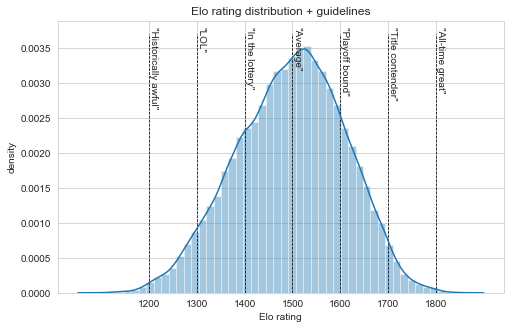

In [10]:
#plot distribution with "summary" overlay
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_team_elo['elo_post'], axlabel='Elo rating', ax=ax);
for x in elo_summary.keys():
    ax.text(x, ax.get_ybound()[-1], '"{}"'.format(elo_summary[x]), rotation=270);
plt.vlines(elo_summary.keys(), ax.get_ybound()[0], ax.get_ybound()[-1],
           color='black', linestyles='dashed', linewidth=.75);
plt.title('Elo rating distribution + guidelines');

In [11]:
df_nba_team_elo['elo_post'].describe()

count    136790.000000
mean       1496.543474
std         112.499741
min        1085.774400
25%        1418.646150
50%        1502.289500
75%        1577.022375
max        1865.449075
Name: elo_post, dtype: float64

At first glance, the data stands just a bit off from FiveThirtyEight's descriptions. About half of teams make the playoffs in a given year, yet that percentile squarely considered "Average".

These descriptions could be considered as centerlines within their respective categories. We can view these ranges as proportions of teams historically:

In [12]:
# define ranges based on elo_summary
elo_range_summary = {
    elo_summary.get(1800): (1750, math.inf),
    elo_summary.get(1700): (1650, 1750),
    elo_summary.get(1600): (1550, 1650),
    elo_summary.get(1500): (1450, 1550),
    elo_summary.get(1400): (1350, 1450),
    elo_summary.get(1300): (1250, 1350),
    elo_summary.get(1200): (-math.inf, 1250)}

print('Historically,')

for description, elo_range in elo_range_summary.items():
    
    # calc % of postgame elo ratings for this category
    print('{}% of Elo ratings have qualified as "{}"'.format((df_nba_team_elo.query(
        'elo_post > {} and elo_post <= {}'.format(elo_range[0], elo_range[1]))['elo_post'].count()
         / len(df_nba_team_elo) * 100).round(2), description))

Historically,
0.6% of Elo ratings have qualified as "All-time great"
7.73% of Elo ratings have qualified as "Title contender"
25.14% of Elo ratings have qualified as "Playoff bound"
33.19% of Elo ratings have qualified as "Average"
22.65% of Elo ratings have qualified as "In the lottery"
9.15% of Elo ratings have qualified as "LOL"
1.54% of Elo ratings have qualified as "Historically awful"


Checking the distribution of playoff Elos vs. regular season Elos (Not a perfect assessment of "playoff bound" teams, but a close enough proxy that also shows how the distribution shifts as a season moves to post-season):

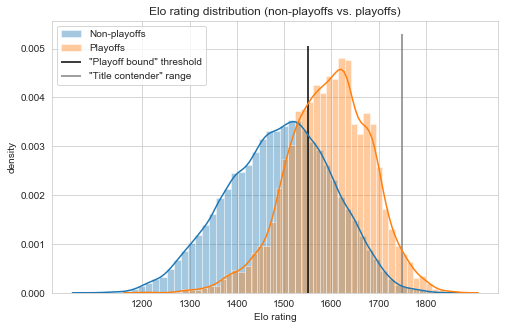

In [15]:
#plot non-playoff and playoff distributions (normalized)
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_team_elo[df_nba_team_elo['playoff'].isnull()]['elo_post'],
             label='Non-playoffs', axlabel='Elo rating', ax=ax);
sns.distplot(df_nba_team_elo[df_nba_team_elo['playoff'].isnull() == False]['elo_pre'],
             label='Playoffs', axlabel='Elo rating', ax=ax)
plt.vlines(elo_range_summary['Playoff bound'][0],
           ax.get_ybound()[0], ax.get_ybound()[-1], color='black', label='"Playoff bound" threshold');
plt.vlines(elo_range_summary['Title contender'][1],
           ax.get_ybound()[0], ax.get_ybound()[-1], color='grey', label='"Title contender" range');
plt.legend(loc='upper left');
plt.title('Elo rating distribution (non-playoffs vs. playoffs)');

This definition of "playoff bound" checks out. The *playoffs* distribution centers just between "playoff bound" and "title contender." Average-performing teams in earlier playoff rounds likely create the fatter tail to the left (after all, there are more games in earlier rounds).

Since we will be considering "great" teams, we should also check how many "title contenders" realistically end up winning the title. The following distribution breaks up championship teams by regular season and playoff ratings - giving an idea of how often Elo might have considered a team to be "title contender" or better:

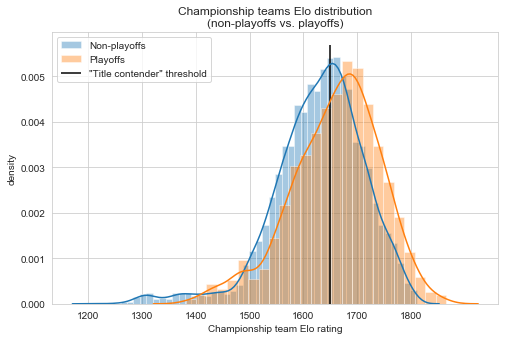

In [17]:
#merged Elo ratings and champion teams
df_nba_champ_elo = df_nba_team_elo.merge(
    df_seasons, how='inner', left_on=['season', 'team'], right_on=['season', 'champion'])

#plot non-playoff and playoff distributions (normalized)
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_champ_elo[df_nba_champ_elo['playoff'].isnull()]['elo_post'],
             label='Non-playoffs', axlabel='Championship team Elo rating', ax=ax);
sns.distplot(df_nba_champ_elo[df_nba_champ_elo['playoff'].isnull() == False]['elo_pre'],
             label='Playoffs', axlabel='Championship team Elo rating', ax=ax)
plt.vlines(elo_range_summary['Title contender'][0],
           ax.get_ybound()[0], ax.get_ybound()[-1], color='black', label='"Title contender" threshold');
plt.legend(loc='upper left');
plt.title('Championship teams Elo distribution\n(non-playoffs vs. playoffs)');

It's interesting and encouraging that the regular season distribution centers pretty much on our "title contender" threshold. Then the distribution shifts rightward during the playoffs - as would be expected, assuming that the best teams notably separate themselves from the pack over the course of a season and post-season (on average).

This suggests that we can confidently compare the overall season average of a team to see whether they *should* have been considered a contender for that season (whether or not they were lucky enough to win it all).

We are also interested to know how the historical Elo distribution looks like for specific teams - since much of "greatness" is based on reputation. One would expect the most consistently great all-time teams (like the Boston Celtics and Los Angeles Lakers) to look different from teams that have fluctuated over the years. For comparison:

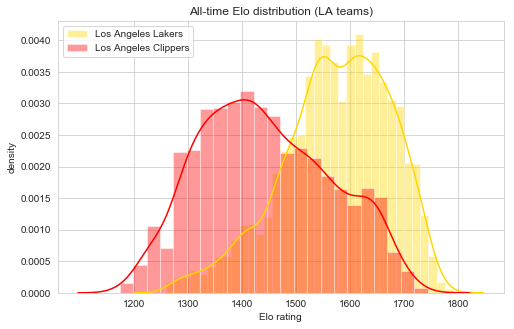

In [20]:
#plot team Elo distributions
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_team_elo[df_nba_team_elo['team'] == 'LAL']['elo_post'],
             axlabel='Elo rating', label='Los Angeles Lakers', color='gold', ax=ax);
sns.distplot(df_nba_team_elo[df_nba_team_elo['team'] == 'LAC']['elo_post'],
             axlabel='Elo rating', label='Los Angeles Clippers', color='red', ax=ax);
plt.legend(loc='upper left');
plt.title('All-time Elo distribution (LA teams)');

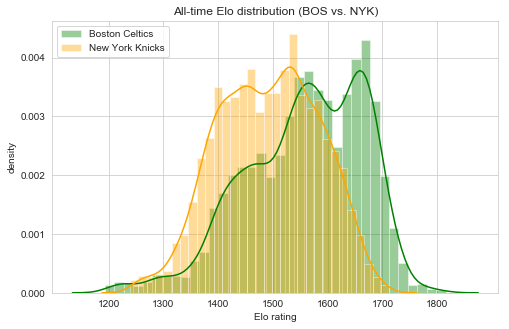

In [21]:
#plot team Elo distributions
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_team_elo[df_nba_team_elo['team'] == 'BOS']['elo_post'],
             axlabel='Elo rating', label='Boston Celtics', color='green', ax=ax);
sns.distplot(df_nba_team_elo[df_nba_team_elo['team'] == 'NYK']['elo_post'],
             axlabel='Elo rating', label='New York Knicks', color='orange', ax=ax);
plt.legend(loc='upper left');
plt.title('All-time Elo distribution (BOS vs. NYK)');

We can infer that the more pronounced split for the Celtics and Lakers represent a difference between peak good years and peak "average" seasons for these teams. The Clippers - long known as a historically bad team - show a flatter distribution, biased toward the low-end of the Elo spectrum.

The Celtics and Lakers have also had some pretty low years, and mostly average years. There is surprisingly little separation between the Celtics' and Knicks' distributions, considering all the championships Boston has won (17) compared to New York (2) in the same number of seasons. Perhaps this suggests that Boston has historically overperformed in the playoffs, while New York has underperformed.

Looking at my hometown team - the San Antonio Spurs - for good measure:

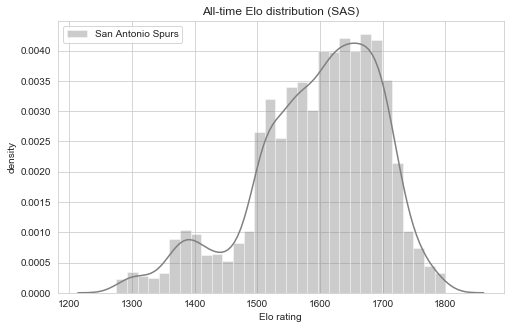

In [22]:
#plot team Elo distribution
fig, ax = plt.subplots(figsize=(8, 5));
ax.set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(df_nba_team_elo[df_nba_team_elo['team'] == 'SAS']['elo_post'],
             axlabel='Elo rating', label='San Antonio Spurs', color='grey', ax=ax);
plt.legend(loc='upper left');
plt.title('All-time Elo distribution (SAS)');

The Spurs (5 championships) look like pretty much a definiton of perennial contenders! Much of the distribution falls in "title contender" range, although the Elo peak is not as high as the Celtics'.
<!-- ### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations? -->
<!--### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?-->

## Bivariate Exploration

In order to understand the time component of Elo over seasons, let's look at the overall average, max, and minimums:

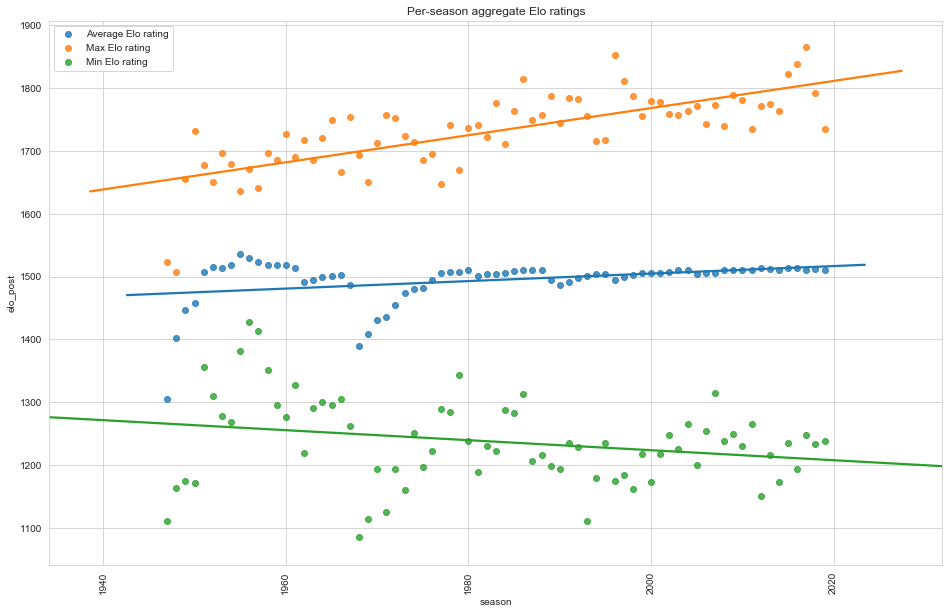

In [23]:
#plot aggregate Elo descriptives over time
fig, ax = plt.subplots(figsize=(16, 10));
ax.set(xlabel='season')

#groupby season for calcs
groupby_season_elo = df_nba_team_elo.groupby('season')

sns.regplot(
    data = groupby_season_elo[['elo_post']].mean().reset_index().astype(int),
    x = 'season', y = 'elo_post', ci=None, label='Average Elo rating', ax=ax);

sns.regplot(
    data = groupby_season_elo[['elo_post']].max().reset_index().astype(int),
    x = 'season', y = 'elo_post', ci=None, label='Max Elo rating', ax=ax);

sns.regplot(
    data = groupby_season_elo[['elo_post']].min().reset_index().astype(int),
    x = 'season', y = 'elo_post', ci=None, label='Min Elo rating', ax=ax);

plt.xticks(rotation='vertical')
plt.legend(loc='upper left');
plt.title('Per-season aggregate Elo ratings');

The mean fluctuates more than expected - specifically before the NBA/ABA league merger in 1976. This implies at least a few things:
1. More parity between teams in the early days, more pronounced shifts in performance
2. Lower scores (before the shot clock was instituted) which could throw off the Elo calculation
3. The existence of different leagues with different characteristics (which unfortunately is not captured in the Elo data)

The earlier seasons look to be createing a fatter leftward tail in the distributions we saw earlier. Here are the same plots, from the merger onwards (a.k.a. the NBA's "modern era"):

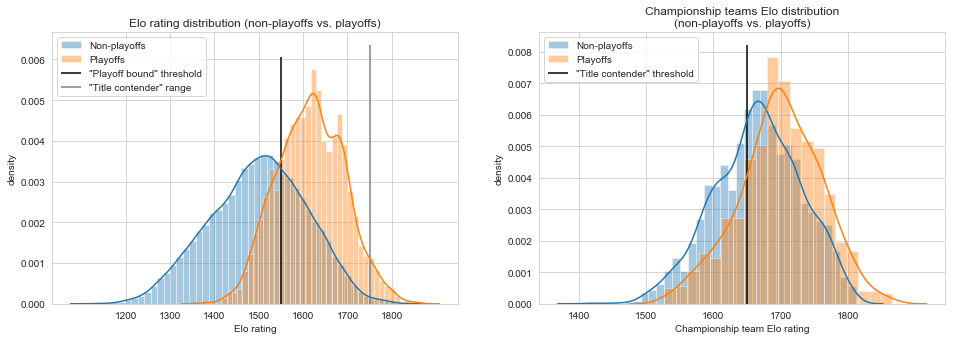

In [26]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=2, nrows=1);

#plot non-playoff and playoff distributions 1977+ (normalized)
axs[0].set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(
    df_nba_team_elo.query('playoff.isnull() and season.astype("int") > 1976', engine='python')['elo_post'],
    label='Non-playoffs', axlabel='Elo rating', ax=axs[0]);
sns.distplot(
    df_nba_team_elo.query('not playoff.isnull() and season.astype("int") > 1976', engine='python')['elo_pre'],
             label='Playoffs', axlabel='Elo rating', ax=axs[0])
axs[0].vlines(elo_range_summary['Playoff bound'][0],
              axs[0].get_ybound()[0], axs[0].get_ybound()[-1], color='black', label='"Playoff bound" threshold');
axs[0].vlines(elo_range_summary['Title contender'][1],
           axs[0].get_ybound()[0], axs[0].get_ybound()[-1], color='grey', label='"Title contender" range');
axs[0].legend(loc='upper left');

#plot champion non-playoff and playoff distributions 1977+ (normalized)
axs[1].set(ylabel='density', xticks=list(elo_summary.keys()))
sns.distplot(
    df_nba_champ_elo.query('playoff.isnull() and season.astype("int") > 1976', engine='python')['elo_post'],
             label='Non-playoffs', axlabel='Championship team Elo rating', ax=axs[1]);
sns.distplot(
    df_nba_champ_elo.query('not playoff.isnull() and season.astype("int") > 1976', engine='python')['elo_pre'],
             label='Playoffs', axlabel='Championship team Elo rating', ax=axs[1])
axs[1].vlines(elo_range_summary['Title contender'][0],
              axs[1].get_ybound()[0], axs[1].get_ybound()[-1], color='black', label='"Title contender" threshold');
axs[1].legend(loc='upper left');
axs[0].set_title('Elo rating distribution (non-playoffs vs. playoffs)');
axs[1].set_title('Championship teams Elo distribution\n(non-playoffs vs. playoffs)');

As expected, the distributions are more uniform now. For clarity and consistentcy, let's now only consider the "modern era" when looking at these categories.

Note that this drops the great Boston Celtics teams of the 1960's. However, their 1980's dynasty will still be included.

In [27]:
#define "modern era" seasons for further analysis
nba_modern_era_seasons = [str(i) for i in range(1977, 2019)]

The Elo mean creeps up over time might be explained by some degree of autocorrelation, as mentioned in FiveThirtyEight's explainer article. However, their algorithm and season-by-season reset tries to correct for this.

Regarding the separation between max and min ratings, conventional wisdom suggests that this becomes more pronounced as historically "great" ("title contender") teams have gradually set themselves apart.

Grouping team Elo by season supports the idea that we could use this metric as a proxy for historical "greatness." For example, looking at the Celtics and Lakers vs. the overall average:

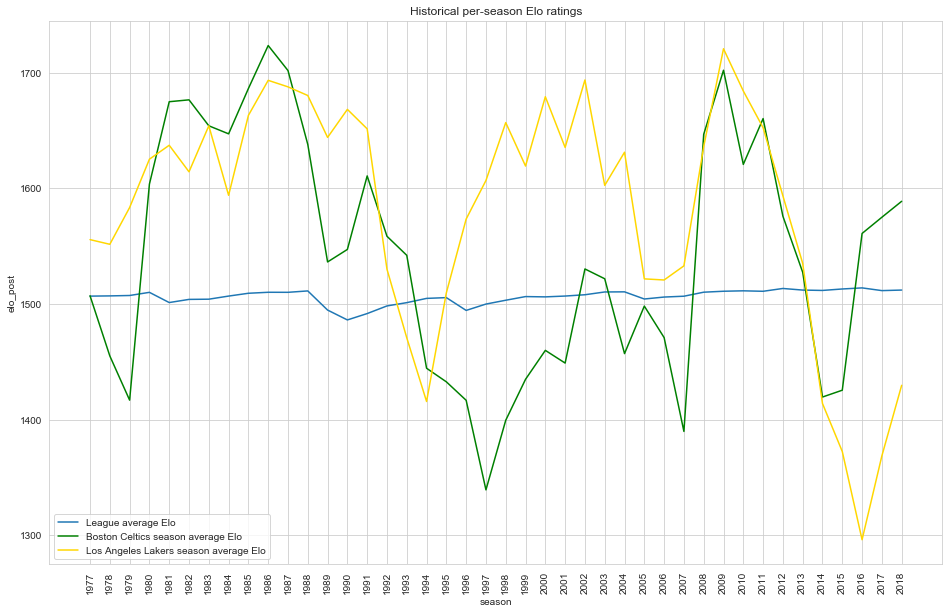

In [28]:
#plot modern-era team Elo trends over time
fig, ax = plt.subplots(figsize=(16, 10));
ax.set(xlabel='season')

#groupby team by season for viz
groupby_season_team_elo = df_nba_team_elo[
    df_nba_team_elo['season'].isin(nba_modern_era_seasons)].groupby(['season', 'team'])

#league average elo_post
sns.lineplot(data = groupby_season_elo[['elo_post']].mean().reset_index().query(
    'season.isin({})'.format(nba_modern_era_seasons), engine='python').astype(float),
    x='season', y='elo_post', label='League average Elo', ax=ax)

#mean elo_post for BOS
sns.lineplot(data = groupby_season_team_elo[['elo_post']].mean().reset_index().query(
    'team == "BOS"')[['season', 'elo_post']].astype(float), 
    x='season', y='elo_post', label='Boston Celtics season average Elo', color='green', ax=ax);

#mean elo_post for LAL
sns.lineplot(data = groupby_season_team_elo[['elo_post']].mean().reset_index().query(
    'team == "LAL"')[['season', 'elo_post']].astype(float), 
    x='season', y='elo_post', label='Los Angeles Lakers season average Elo', color='gold', ax=ax);

plt.xticks(list(map(int, nba_modern_era_seasons)), rotation='vertical');
plt.title('Historical per-season Elo ratings');

We can see the great teams of Magic Johnson (Lakers) and Larry Bird (Celtics) in the 1980s. The Lakers dynasty of the early 2000s (with Shaquille O'Neal and Kobe Bryans) also stand out.

A ranking of the "great" teams according to Elo, based on number of seasons in "title contender" or better territory:
<!-- ### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?-->

<!-- Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?-->

In [29]:
#regroup and count "title contending" seasons by team
groupby_season_team_elo[['elo_post']].mean().reset_index().query(
    'elo_post >= {}'.format(elo_range_summary['Title contender'][0])).groupby(
    'team').size().sort_values(ascending=False)

team
SAS    17
LAL    13
BOS     8
CHI     7
SEA     5
DET     4
GSW     4
MIA     4
UTA     4
POR     4
OKC     3
PHI     3
DAL     3
CLE     3
LAC     2
PHO     2
SAC     2
MIL     2
NYK     1
ORL     1
HOU     1
dtype: int64

## Multivariate Exploration
Getting to the meat of comparing Elo against conventional wisdom, some questions we might ask: Do Elo metrics help us rank the contenders in a given season? Does a historically "great" team have an advantage over a top seeded one?

Who should be given the advantage could be considered based on:
- Season average Elo
- End-of-season (beginning of playoffs) Elo
- Biggest change in Elo over the season

(or all of these)

Here we will use the *seasons* results data to generate and benchmark these ratings.

In [30]:
#create a df to add "great team" elo info to seasons data
df_seasons_elo = df_seasons.copy()

#only consider "modern" seasons for comparable analysis
df_seasons_elo.drop(index = df_seasons_elo.index[
    df_seasons_elo['season'].isin(nba_modern_era_seasons) == False].tolist(),
    inplace = True)

df_seasons_elo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 4 columns):
season      42 non-null object
lg          42 non-null object
top_seed    42 non-null object
champion    42 non-null object
dtypes: object(4)
memory usage: 1.6+ KB


In [31]:
df_seasons_elo['eos_top_elo'] = 0                      # best Elo rating at end of the season
df_seasons_elo['eos_top_elo_team'] = str(np.NaN)       # team with best Elo rating at end of the season

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this season
    groupby_team = df_nba_team_elo[df_nba_team_elo['season'] == row['season']].groupby('team')

    groupby_team_max_date = groupby_team['date'].max() # last date of the season per-team

    #find the highest elo
    for team, date in groupby_team_max_date.iteritems():

        eos_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, date))['elo_post']

        if eos_team_elo.values[0] > df_seasons_elo.loc[idx, 'eos_top_elo']:
            df_seasons_elo.loc[idx, 'eos_top_elo'] = eos_team_elo.values[0]
            df_seasons_elo.loc[idx, 'eos_top_elo_team'] = team

print('Best Elo ratings at end of the season:') #quick viz
df_seasons_elo[['season', 'eos_top_elo', 'eos_top_elo_team']].head()

Best Elo ratings at end of the season:


,season,eos_top_elo,eos_top_elo_team
0,2018,1744.755191,GSW
1,2017,1845.812884,GSW
2,2016,1759.029104,CLE
3,2015,1822.288100,GSW
4,2014,1764.336700,SAS


In [32]:
df_seasons_elo['top_avg_elo'] = 0                      # best average Elo for the season
df_seasons_elo['top_avg_elo_team'] = str(np.NaN)       # team with best average Elo for the season

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this season
    groupby_team = df_nba_team_elo[df_nba_team_elo['season'] == row['season']].groupby('team')

    groupby_team_avg_elo = groupby_team['elo_post'].mean() # average elo for the season

    df_seasons_elo.loc[idx, 'top_avg_elo'] = groupby_team_avg_elo.max()
    df_seasons_elo.loc[idx, 'top_avg_elo_team'] = groupby_team_avg_elo.idxmax()
        
print('Best average Elo ratings for the season:') #quick viz
df_seasons_elo[['season', 'top_avg_elo', 'top_avg_elo_team']].head()

Best average Elo ratings for the season:


,season,top_avg_elo,top_avg_elo_team
0,2018,1703.276520,GSW
1,2017,1758.121615,GSW
2,2016,1798.323629,GSW
3,2015,1725.574764,GSW
4,2014,1696.635200,SAS


In [33]:
df_seasons_elo['top_elo_delta'] = 0                    # best change in Elo over the season
df_seasons_elo['top_elo_delta_team'] = str(np.NaN)     # team with best change in Elo over the season

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this season
    groupby_team = df_nba_team_elo[df_nba_team_elo['season'] == row['season']].groupby('team')

    groupby_team_min_date = groupby_team['date'].min() # first date of the season per-team
    groupby_team_max_date = groupby_team['date'].max() # last date of the season per-team

    #find the highest delta
    for team, date in groupby_team_min_date.iteritems():

        bos_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, date))['elo_pre']

        eos_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, groupby_team_max_date[team]))['elo_post']

        team_elo_delta = eos_team_elo.values[0] - bos_team_elo.values[0]

        if team_elo_delta > df_seasons_elo.loc[idx, 'top_elo_delta']:
            df_seasons_elo.loc[idx, 'top_elo_delta'] = team_elo_delta
            df_seasons_elo.loc[idx, 'top_elo_delta_team'] = team

print('Best changes in Elo rating over the season:') #quick viz
df_seasons_elo[['season', 'top_elo_delta', 'top_elo_delta_team']].head()

Best changes in Elo rating over the season:


,season,top_elo_delta,top_elo_delta_team
0,2018,261.500965,PHI
1,2017,152.833635,GSW
2,2016,180.803290,OKC
3,2015,231.490500,GSW
4,2014,187.930200,PHO


If we compare the same metrics for the regular season vs. playoffs, it will provide an idea of how well Elo predicts postseason performance.

In [34]:
df_seasons_elo['bop_top_elo'] = 0                      # best Elo rating at beginning of playoffs
df_seasons_elo['bop_top_elo_team'] = str(np.NaN)       # team with best Elo rating at beginning of playoffs

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this playoffs
    groupby_playoff_team = df_nba_team_elo.query(
        'season == "{}" and not playoff.isnull()'.format(row['season']), engine='python').groupby('team')

    groupby_playoff_team_min_date = groupby_playoff_team['date'].min() # first date of the playoffs per-team

    #find the highest elo
    for team, date in groupby_playoff_team_min_date.iteritems():

        bop_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, date))['elo_pre']

        if bop_team_elo.values[0] > df_seasons_elo.loc[idx, 'bop_top_elo']:
            df_seasons_elo.loc[idx, 'bop_top_elo'] = bop_team_elo.values[0]
            df_seasons_elo.loc[idx, 'bop_top_elo_team'] = team

print('Best Elo ratings at beginning of playoffs:') #quick viz
df_seasons_elo[['season', 'bop_top_elo', 'bop_top_elo_team']].head()

Best Elo ratings at beginning of playoffs:


,season,bop_top_elo,bop_top_elo_team
0,2018,1732.213741,HOU
1,2017,1769.617890,GSW
2,2016,1788.472611,GSW
3,2015,1772.346900,GSW
4,2014,1694.790200,SAS


In [35]:
df_seasons_elo['reg_top_avg_elo'] = 0                  # best average Elo for the regular season
df_seasons_elo['reg_top_avg_elo_team'] = str(np.NaN)   # team with best average Elo for the regular season

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this regular season
    groupby_team = df_nba_team_elo.query(
        'season == "{}" and playoff.isnull()'.format(row['season']), engine='python').groupby('team')

    groupby_team_avg_elo = groupby_team['elo_post'].mean() # average elo for the regular season

    df_seasons_elo.loc[idx, 'reg_top_avg_elo'] = groupby_team_avg_elo.max()
    df_seasons_elo.loc[idx, 'reg_top_avg_elo_team'] = groupby_team_avg_elo.idxmax()
        
print('Best average Elo ratings for the regular season:') #quick viz
df_seasons_elo[['season', 'reg_top_avg_elo', 'reg_top_avg_elo_team']].head()

Best average Elo ratings for the regular season:


,season,reg_top_avg_elo,reg_top_avg_elo_team
0,2018,1714.604825,GSW
1,2017,1744.963551,GSW
2,2016,1800.944849,GSW
3,2015,1708.866411,GSW
4,2014,1693.197956,SAS


In [36]:
df_seasons_elo['reg_top_elo_delta'] = 0                # best change in Elo over the regular season
df_seasons_elo['reg_top_elo_delta_team'] = str(np.NaN) # team with best change in Elo over the regular season

for idx, row in df_seasons_elo.iterrows():
        
    #group by team for this regular season
    groupby_team = df_nba_team_elo.query(
        'season == "{}" and playoff.isnull()'.format(row['season']), engine='python').groupby('team')

    groupby_team_min_date = groupby_team['date'].min() # first date of the regular season per-team
    groupby_team_max_date = groupby_team['date'].max() # last date of the regular season per-team

    #find the highest delta
    for team, date in groupby_team_min_date.iteritems():

        reg_beg_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, date))['elo_pre']

        reg_end_team_elo = df_nba_team_elo.query(
            'team == "{}" and date == "{}"'.format(team, groupby_team_max_date[team]))['elo_post']

        team_elo_delta = reg_end_team_elo.values[0] - reg_beg_team_elo.values[0]

        if team_elo_delta > df_seasons_elo.loc[idx, 'reg_top_elo_delta']:
            df_seasons_elo.loc[idx, 'reg_top_elo_delta'] = team_elo_delta
            df_seasons_elo.loc[idx, 'reg_top_elo_delta_team'] = team

print('Best changes in Elo rating over the regular season:') #quick viz
df_seasons_elo[['season', 'reg_top_elo_delta', 'reg_top_elo_delta_team']].head()

Best changes in Elo rating over the regular season:


,season,reg_top_elo_delta,reg_top_elo_delta_team
0,2018,280.834446,PHI
1,2017,105.464944,DEN
2,2016,158.516591,CHO
3,2015,181.968400,UTA
4,2014,196.749100,CHO


Let's look at a summary:

In [37]:
# highlight championship teams and add summary stats in output

seasons_elo_summary = df_seasons_elo.style.apply(
    lambda row: ['border: solid; border-color: orange' if val == row['champion'] else '' for val in row],
    axis=1).render().rsplit('</tbody>', 1)[0]

seasons_elo_summary += '<tr style="text-align: right; font-weight: bold;">'
seasons_elo_summary += '<td colspan="3">Proportion matching champion</td>'

#top seed
seasons_elo_summary += '<td>top_seed<br/>{}</td>'.format(
    (df_seasons_elo['top_seed'] == df_seasons_elo['champion']).mean().round(2))

#champion (1)
seasons_elo_summary += '<td>champion<br/>{}</td>'.format(
    (df_seasons_elo['champion'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best Elo rating at end of the season matching champion
seasons_elo_summary += '<td colspan="2">eos_top_elo<br/>{}</td>'.format(
    (df_seasons_elo['eos_top_elo_team'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best average Elo for the season matching champion
seasons_elo_summary += '<td colspan="2">top_avg_elo<br/>{}</td>'.format(
    (df_seasons_elo['top_avg_elo_team'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best change in Elo over the season matching champion
seasons_elo_summary += '<td colspan="2">top_elo_delta<br/>{}</td>'.format(
    (df_seasons_elo['top_elo_delta_team'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best Elo rating at beginning of playoffs matching champion
seasons_elo_summary += '<td colspan="2">bop_top_elo<br/>{}</td>'.format(
    (df_seasons_elo['bop_top_elo_team'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best average Elo for the regular season matching champion
seasons_elo_summary += '<td colspan="2">reg_top_avg_elo<br/>{}</td>'.format(
    (df_seasons_elo['reg_top_avg_elo_team'] == df_seasons_elo['champion']).mean().round(2))

#proportion of best change in Elo over the regular season matching champion
seasons_elo_summary += '<td colspan="2">reg_top_elo_delta<br/>{}</td>'.format(
    (df_seasons_elo['reg_top_elo_delta_team'] == df_seasons_elo['champion']).mean().round(2))

seasons_elo_summary += '</tr></tbody></table>'

display(HTML(seasons_elo_summary))

,season,lg,top_seed,champion,eos_top_elo,eos_top_elo_team,top_avg_elo,top_avg_elo_team,top_elo_delta,top_elo_delta_team,bop_top_elo,bop_top_elo_team,reg_top_avg_elo,reg_top_avg_elo_team,reg_top_elo_delta,reg_top_elo_delta_team
0,2018,NBA,HOU,GSW,1744.76,GSW,1703.28,GSW,261.501,PHI,1732.21,HOU,1714.6,GSW,280.834,PHI
1,2017,NBA,GSW,GSW,1845.81,GSW,1758.12,GSW,152.834,GSW,1769.62,GSW,1744.96,GSW,105.465,DEN
2,2016,NBA,GSW,CLE,1759.03,CLE,1798.32,GSW,180.803,OKC,1788.47,GSW,1800.94,GSW,158.517,CHO
3,2015,NBA,GSW,GSW,1822.29,GSW,1725.57,GSW,231.49,GSW,1772.35,GSW,1708.87,GSW,181.968,UTA
4,2014,NBA,SAS,SAS,1764.34,SAS,1696.64,SAS,187.93,PHO,1694.79,SAS,1693.2,SAS,196.749,CHO
5,2013,NBA,MIA,MIA,1754.19,MIA,1703.86,MIA,191.484,BRK,1757.01,MIA,1692.75,OKC,208.477,BRK
6,2012,NBA,SAS,MIA,1733.28,SAS,1676.05,MIA,147.86,SAS,1716.36,SAS,1680.06,MIA,137.03,LAC
7,2011,NBA,CHI,DAL,1735.93,DAL,1662.86,SAS,183.548,CHI,1712.23,CHI,1665.95,SAS,221.215,CHI
8,2010,NBA,CLE,LAL,1744.27,ORL,1715.13,CLE,193.066,OKC,1720.39,ORL,1717.9,CLE,203.046,OKC
9,2009,NBA,CLE,LAL,1789.99,LAL,1720.71,LAL,193.848,CLE,1724.89,CLE,1713.82,LAL,191.239,POR


Several things of note here:

- The end-of season top Elo makes sense as having the best accuracy for matching the eventual champion, but of course this couldn't be used to predict success before playoffs start in a given season. 

- Even the end-of-season top Elo only matches a champion about 3/4 of the time. Top-Elo teams that didn't win could be considered disappointments. In these seasons, such as the 2012 San Antonio Spurs, we see teams with great seasons that underperformed or were upset in the playoffs. On the flip side, there are a handful of teams (especially in earlier seasons) that have won the championship without piercing our "title contender" threshold. So we see a limitation of Elo here.

- The team with the top Elo at the beginning of the playoffs only wins less than 50% of the time - so the team that has elevated themselves at that point is not necessarily going to win it all! The success rate is slightly higher than a top seed, however. We see the same performance with the top average Elo, although this is not always the same team.

- The top change in Elo comes from Boston in 2008 - not widely regarded as a surprise champion, perhaps given Boston's reputation for greatness. A reputation which helped the team sign a few star free agents that year. This delta would suggest they had a truly historic the season! The #2 and #3 biggest changes came from San Antonio, in turnaround seasons after drafting the great players David Robinson and Tim Duncan.

- The change in Elo over a season is a notable stat. Given that the regular season delta is mostly turnaround / improved teams (not necessarily great / championship teams), the Elo difference shows that the best teams separate themselves during the playoffs. Maybe this is obvious - champions tend not to play many close, long-running series with "just good" teams. This insight also corresponds to the popular notion that some great teams can "flip a switch," elevating their play come playoff time.

- Comparing across metrics, the most dominant teams clearly rule both the regular season and postseason (2000 LAL, 1996 CHI, 1986 BOS, etc.). A team who topped all of these stats together in the reg season has always won the championship.

In terms of predicting a championship team at the beginning of a given playoffs, we should see top Elo and top average Elo to be similarly useful using regression. Getting the data to fit Logit models:

In [38]:
# we will fit the model based on playoff teams, each year, with elo outcomes
df_playoff_teams_elo = pd.DataFrame(
    columns = ['season', 'team','is_champion','is_bop_top_elo',
               'is_reg_top_avg_elo', 'is_reg_top_elo_delta', 'is_top_seed'])

#fill teams for each season
for idx, row in df_seasons_elo.iterrows():
    
    for team in df_nba_team_elo.query(
        'season == "{}" and not playoff.isnull()'.format(row['season']),engine='python')['team'].unique():
        
        df_playoff_teams_elo = df_playoff_teams_elo.append({
            'season': row['season'],
            'team': team,
            'is_champion': (team == row['champion']),
            'is_bop_top_elo': (team == row['bop_top_elo_team']),
            'is_reg_top_avg_elo': (team == row['reg_top_avg_elo_team']),
            'is_reg_top_elo_delta': (team == row['reg_top_elo_delta_team']),
            'is_top_seed': (team == row['top_seed'])
        }, ignore_index=True)

df_playoff_teams_elo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 7 columns):
season                  644 non-null object
team                    644 non-null object
is_champion             644 non-null object
is_bop_top_elo          644 non-null object
is_reg_top_avg_elo      644 non-null object
is_reg_top_elo_delta    644 non-null object
is_top_seed             644 non-null object
dtypes: object(7)
memory usage: 35.3+ KB


In [39]:
# fit model based on best Elo rating at beginning of playoffs matching champion
Log_model = sm.Logit(df_playoff_teams_elo['is_champion'].astype(int), sm.add_constant(
    df_playoff_teams_elo[['is_bop_top_elo']].astype(int)))
Log_model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.191709
         Iterations 7


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_champion   No. Observations:                  644
Model:                          Logit   Df Residuals:                      642
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 May 2019   Pseudo R-squ.:                  0.2048
Time:                        11:23:36   Log-Likelihood:                -123.46
converged:                       True   LL-Null:                       -155.26
                                        LLR p-value:                 1.523e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.2720      0.217    -15.064      0.000      -3.698      -2.846
is_bop_top_elo     3.1767      0.378      8.411      0.000       2.436       3.917
==================================================================================
"""

In [40]:
# fit model based on best average Elo for the regular season matching champion
Log_model = sm.Logit(df_playoff_teams_elo['is_champion'].astype(int), sm.add_constant(
    df_playoff_teams_elo[['is_reg_top_avg_elo']].astype(int)))
Log_model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.191709
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_champion   No. Observations:                  644
Model:                          Logit   Df Residuals:                      642
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 May 2019   Pseudo R-squ.:                  0.2048
Time:                        11:23:38   Log-Likelihood:                -123.46
converged:                       True   LL-Null:                       -155.26
                                        LLR p-value:                 1.523e-15
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.2720      0.217    -15.064      0.000      -3.698      -2.846
is_reg_top_avg_elo     3.1767      0.378      8.411      0.000       2.436       3.917
======================================================================================
"""

These fits suggest that a team with the top Elo or top average Elo in a regular season is about 24x more likely to be champs than other playoff teams (based on Logit coefficient). If we dug deeper (for example into the top-2 of each category), we might find even stronger correlation.

This fit further supports the idea that Elo is predictive - not just descriptive - of playoff success. It also supports the idea that historically great teams tend to set themselves apart in the playoffs.

Notably, compared to the top seed (i.e. top record) in a given season, Elo does predict championships a bit better:

In [41]:
# fit model with top seed
Log_model = sm.Logit(df_playoff_teams_elo['is_champion'].astype(int), sm.add_constant(
    df_playoff_teams_elo[['is_top_seed']].astype(int)))
Log_model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.201134
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_champion   No. Observations:                  644
Model:                          Logit   Df Residuals:                      642
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 May 2019   Pseudo R-squ.:                  0.1657
Time:                        11:23:41   Log-Likelihood:                -129.53
converged:                       True   LL-Null:                       -155.26
                                        LLR p-value:                 7.302e-13
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1815      0.208    -15.272      0.000      -3.590      -2.773
is_top_seed     2.8938      0.375      7.717      0.000       2.159       3.629
===============================================================================
"""

Much is also made about win streaks as historical proof of a team's greatness. So what do the longest win streaks look like in terms of Elo?

The following cell calculates streaks in each regular season (# of wins and team Elo delta):

In [42]:
# dataframe to save streak data for visualization
df_nba_streaks_elo = pd.DataFrame(
    columns = ['season', 'team','streak_count','start_date', 'end_date', 'elo_delta'])

# get longest win streaks (using 10 as arbitrary minimum)
for season in df_nba_team_elo['season'].unique():
    
    print('Calculating streaks in {} season...'.format(season))
    
    for team in df_nba_team_elo[df_nba_team_elo['season'] == season]['team'].unique():
        
        #calculate streaks based on change in elo
        streak = 0
        streak_start_date = dt.time()
        streak_end_date = dt.time()
        streak_elo_start = 0
        streak_elo_end = 0
        
        for row in df_nba_team_elo.query(
            'season == "{}" and team =="{}" and playoff.isnull()'.format(season, team),
            engine='python').sort_values('date')[['elo_pre', 'elo_post', 'date']].iterrows():
            
            if streak == 0: #reset start
                streak_elo_start = row[1][0] #elo_pre
                streak_start_date = row[1][2] #date
            
            if row[1][1] > row[1][0]: # elo_post > elo_pre
                streak += 1
                streak_elo_end = row[1][1] #elo_post
                streak_end_date = row[1][2] #date
            else: #reset end
                
                #add streak to df
                if streak > 10:
                    
                    df_nba_streaks_elo = df_nba_streaks_elo.append({
                        'season': season,
                        'team': team,
                        'streak_count': int(streak),
                        'start_date': streak_start_date,
                        'end_date': streak_end_date,
                        'elo_delta': streak_elo_end - streak_elo_start,
                        'elo_delta_per_game': (streak_elo_end - streak_elo_start) / streak
                    }, ignore_index=True)
                    
                streak = 0
                streak_elo_end = 0
                streak_end_date = dt.time()
                
        if streak > 10: #for streaks to end season
            df_nba_streaks_elo = df_nba_streaks_elo.append({
                'season': season,
                'team': team,
                'streak_count': int(streak),
                'start_date': streak_start_date,
                'end_date': streak_end_date,
                'elo_delta': streak_elo_end - streak_elo_start,
                'elo_delta_per_game': (streak_elo_end - streak_elo_start) / streak
            }, ignore_index=True)
            
df_nba_streaks_elo.info()            

Calculating streaks in 1947 season...
Calculating streaks in 1948 season...
Calculating streaks in 1949 season...
Calculating streaks in 1950 season...
Calculating streaks in 1951 season...
Calculating streaks in 1952 season...
Calculating streaks in 1953 season...
Calculating streaks in 1954 season...
Calculating streaks in 1955 season...
Calculating streaks in 1956 season...
Calculating streaks in 1957 season...
Calculating streaks in 1958 season...
Calculating streaks in 1959 season...
Calculating streaks in 1960 season...
Calculating streaks in 1961 season...
Calculating streaks in 1962 season...
Calculating streaks in 1963 season...
Calculating streaks in 1964 season...
Calculating streaks in 1965 season...
Calculating streaks in 1966 season...
Calculating streaks in 1967 season...
Calculating streaks in 1968 season...
Calculating streaks in 1969 season...
Calculating streaks in 1970 season...
Calculating streaks in 1971 season...
Calculating streaks in 1972 season...
Calculating 

Looking at the top streaks by length:

In [43]:
df_nba_streaks_elo.sort_values('streak_count', ascending=False).head(20)

,season,team,streak_count,start_date,end_date,elo_delta,elo_delta_per_game
31,1972,LAL,33,1971-11-05,1972-01-07,208.841000,6.328515
154,2013,MIA,27,2013-02-03,2013-03-25,121.786900,4.510626
169,2016,GSW,24,2015-10-27,2015-12-11,95.651339,3.985472
136,2008,HOU,22,2008-01-29,2008-03-16,130.675200,5.939782
29,1971,MIL,20,1971-02-06,1971-03-08,100.869300,5.043465
163,2014,SAS,19,2014-02-26,2014-04-02,109.930400,5.785811
107,2000,LAL,19,2000-02-04,2000-03-13,93.545400,4.923442
141,2009,BOS,19,2008-11-15,2008-12-23,83.829500,4.412079
167,2015,ATL,19,2014-12-27,2015-01-31,124.258200,6.539905
26,1970,NYK,18,1969-10-24,1969-11-28,97.194300,5.399683


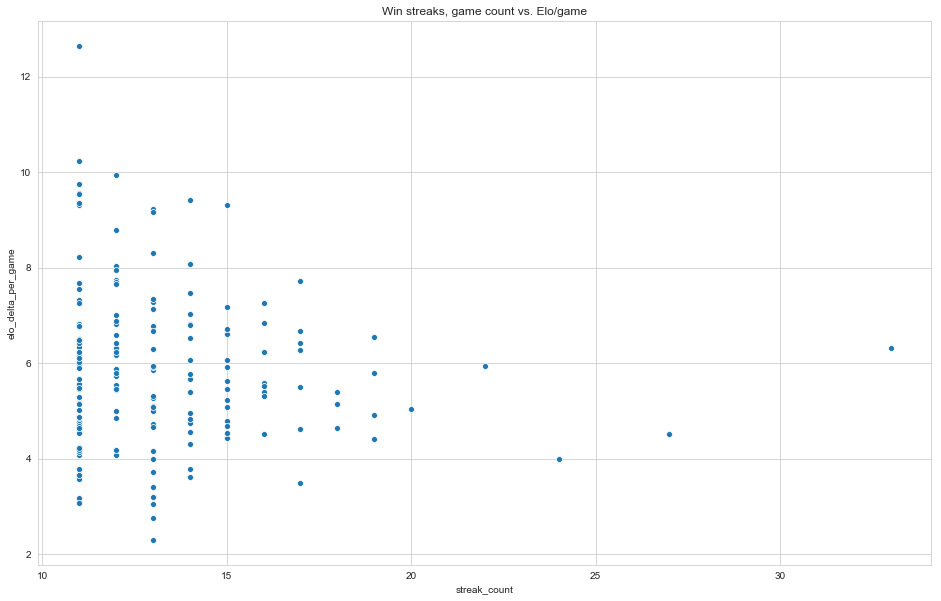

In [46]:
#plot streaks and Elo delta, >10 as arbitrary limit
fig, ax = plt.subplots(figsize=(16, 10));

sns.scatterplot(data = df_nba_streaks_elo[df_nba_streaks_elo['streak_count'] > 10],
               x = 'streak_count', y = 'elo_delta_per_game');
plt.title('Win streaks, game count vs. Elo/game');

We can see some great historical teams in the list, as well as an interesting divergence between Elo delta and length of a streak. For example, Phoenix and Dallas both had 17-game win streaks in 2007, with Phoenix apparently winning in more dominant fashion (they also had a higer Elo and record that year). We might be seeing the "grinding" nature of some win streaks vs. "hot" streaks of others. The Lakers' historic 33-game streak still stands out as a really impressive outlier!

It is surprising to see the BAA's Washington Capitols, from way back in 1947, make an appearance with a dominant 7.7 Elo/game. Since this is before the modern era, however, it is not so comparable to others on this list.
<!--### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?-->
<!--### Were there any interesting or surprising interactions between features?-->

Let's save our transformed data and calculations for further visualization:

In [47]:
df_nba_team_elo.to_csv('nba_team_elo.csv', index=False)       # Elo by-team-by-date
df_nba_streaks_elo.to_csv('nba_streaks_elo.csv', index=False) # >=10 win streaks Elo calculations
df_seasons_elo.to_csv('seasons_elo.csv', index=False)         # Modern era Elo calculations per-season 